In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import rc_context

In [4]:
adata = sc.read_mtx('matrix.mtx').T
genes = pd.read_csv('genes.tsv', sep='\t', header=None, names=['gene_ids', 'genes'])
barcodes = pd.read_csv('barcodes.tsv', sep='\t', header=None, names=['barcodes'])

adata.var = genes
adata.obs = barcodes


In [5]:
adata.var

gene_ids         genes
0      ENSG00000243485    MIR1302-10
1      ENSG00000237613       FAM138A
2      ENSG00000186092         OR4F5
3      ENSG00000238009  RP11-34P13.7
4      ENSG00000239945  RP11-34P13.8
...                ...           ...
32733  ENSG00000215635    AC145205.1
32734  ENSG00000268590         BAGE5
32735  ENSG00000251180    CU459201.1
32736  ENSG00000215616    AC002321.2
32737  ENSG00000215611    AC002321.1

[32738 rows x 2 columns]

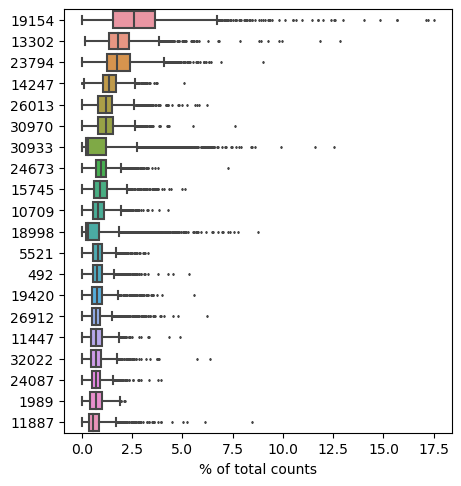

In [6]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata,  n_top=20, ) # y-axis represent the index of genes name in the gene.tsv file

In [7]:
#### before QC
original_adata = adata.copy()


# Perform the necessary preprocessing steps
sc.pp.filter_cells(adata, min_genes=200) # Filtering out low quality cells: any cell that has less than 200 genes detected will be removed from the analysis
sc.pp.filter_genes(adata, min_cells=3) # any genes detected in less than 3 cells will be removed
adata.obs['n_counts'] = adata.X.sum(axis=1)


# Find the mitochondrial genes
mito_genes = adata.var.loc[:,"genes"].str.startswith('MT-')

# Calculate the sum of counts for mitochondrial genes
mito_counts = adata[:, mito_genes].X.sum(axis=1)

# Calculate the total counts for each cell
total_counts = adata.X.sum(axis=1)

# Calculate the percentage of counts in mitochondrial genes
percent_mito = mito_counts / total_counts * 100

# Store the percentage of counts in mitochondrial genes in the obs dataframe
adata.obs['percent_mito'] = percent_mito

print(adata.obs.columns)
print(adata.obs.shape)

print(adata.var.shape)


#sc.pl.violin(original_adata, ['n_genes'], jitter=0.4, multi_panel=True) # before preprocessing , but we need preprocessing to get ['n_genes']


D:\condaa\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['barcodes', 'n_genes', 'n_counts', 'percent_mito'], dtype='object')
(2700, 4)
(13714, 3)


D:\condaa\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
# Compute total counts per cell and percentage of mitochondrial counts

#sc.pp.filter_genes(adata, min_counts=1) 
#print(original_adata.obs.columns)

#sc.pp.calculate_qc_metrics(original_adata, qc_vars=['n_counts'], inplace=True)

#original_adata.var['n_counts'] = original_adata.X.sum(axis=0)


# Create violin plots
#sc.pl.violin(original_adata, ['n_counts'], jitter=0.4, multi_panel=True)


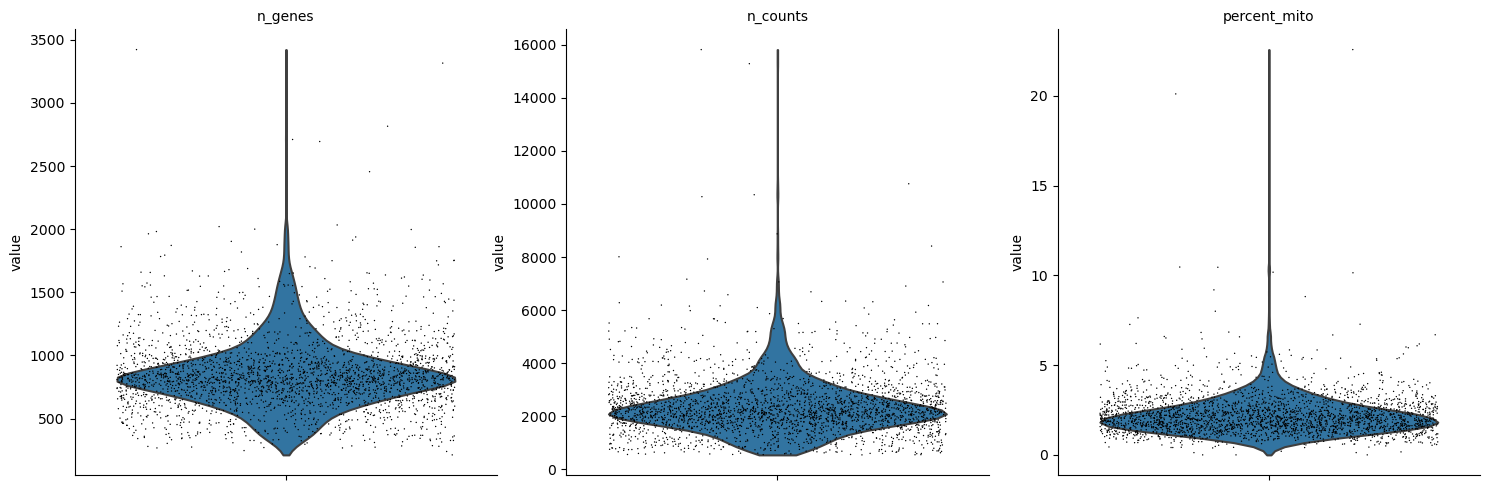

              barcodes  n_genes  n_counts  percent_mito
0     AAACATACAACCAC-1      781    2419.0      3.017776
1     AAACATTGAGCTAC-1     1352    4903.0      3.793596
2     AAACATTGATCAGC-1     1131    3147.0      0.889736
3     AAACCGTGCTTCCG-1      960    2639.0      1.743085
4     AAACCGTGTATGCG-1      522     980.0      1.224490
...                ...      ...       ...           ...
2695  TTTCGAACTCTCAT-1     1155    3459.0      2.110437
2696  TTTCTACTGAGGCA-1     1227    3443.0      0.929422
2697  TTTCTACTTCCTCG-1      622    1684.0      2.197150
2698  TTTGCATGAGAGGC-1      454    1022.0      2.054795
2699  TTTGCATGCCTCAC-1      724    1984.0      0.806452

[2700 rows x 4 columns]


In [9]:

# Plot the violin plot of the percentage of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)

print(adata.obs)

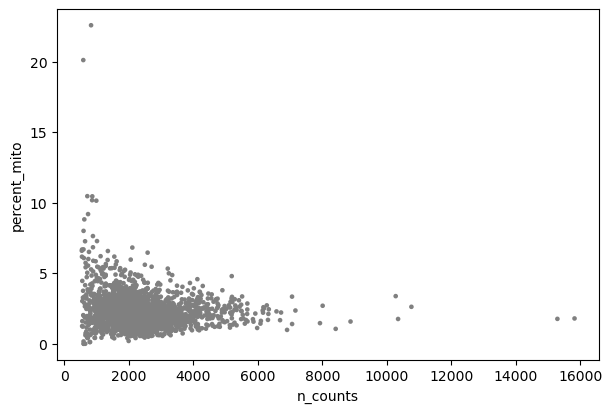

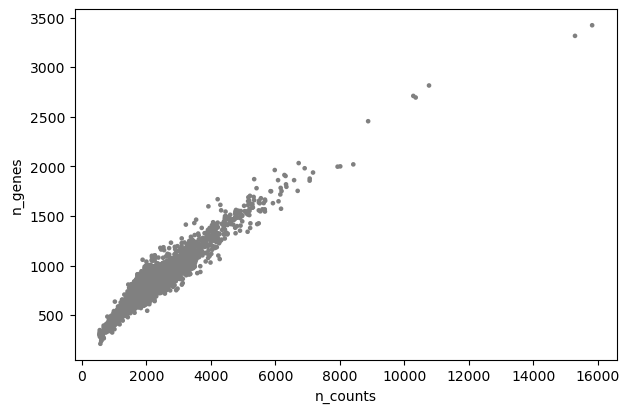

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')


In [11]:
####  AFTER QC
#Remove cells that have too many mitochondrial genes expressed or too many total counts:


adata = adata[adata.obs.n_genes >= 450, :] # filters out cells with RNA features smaller than 300
adata= adata[adata.obs.n_genes < 2000, :] # filters out cells with RNA features greater than 6000
adata = adata[adata.obs.percent_mito < 7, :] # filters out cells with mitochondrial content greater than 10%.

print(adata.obs.shape)
print(adata.var.shape)

(2542, 4)
(13714, 3)


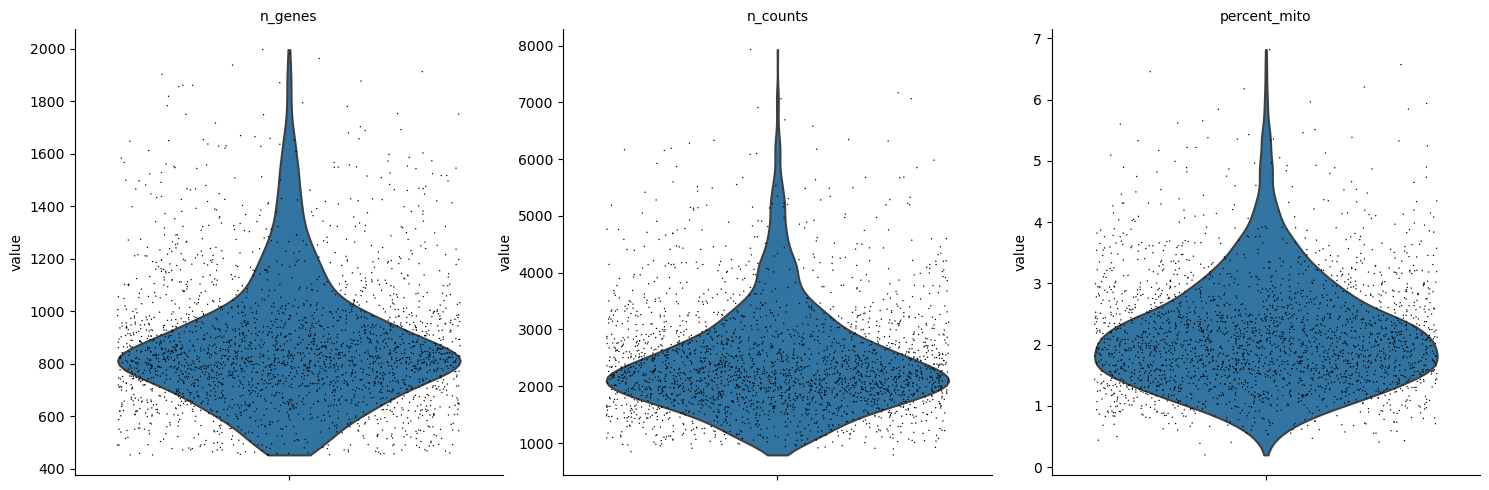

In [12]:
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)


In [13]:
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
#sc.pl.scatter(adata, x='n_counts', y='n_genes')


In [14]:
### normalization

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 
#sc.pp.normalize_total(adata, target_sum=1e6) # This function normalizes the total RNA count in each cell to a specified target sum (1e6 in this case)

D:\condaa\lib\site-packages\scanpy\preprocessing\_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [16]:
### PCA: Dimensionality reduction

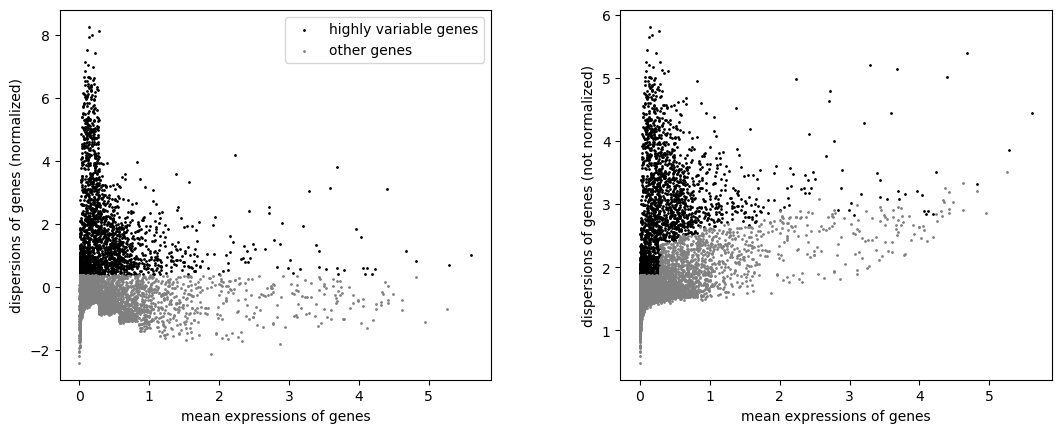

In [17]:
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)


#sc.tl.pca(adata, n_comps=50)


In [18]:
sc.pp.scale(adata, max_value=10) # rescale the expression values of the genes in the data set to a specific range, in this case, to the range [0, 10]

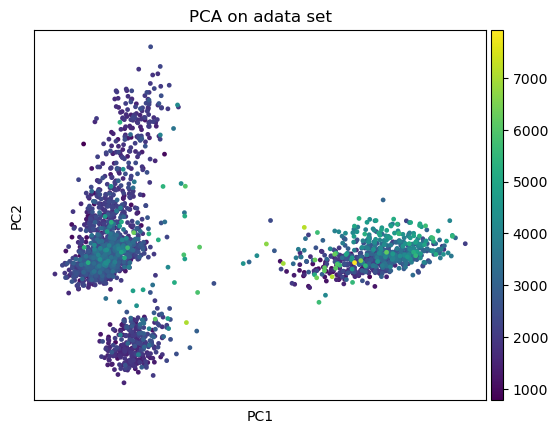

In [19]:
sc.tl.pca(adata)# calculates the first few principal components of the data,
#sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca(adata,color="n_counts", colorbar_loc='right', title='PCA on adata set') #PCA based on the number of RNA per cell, each spot representing a single cell

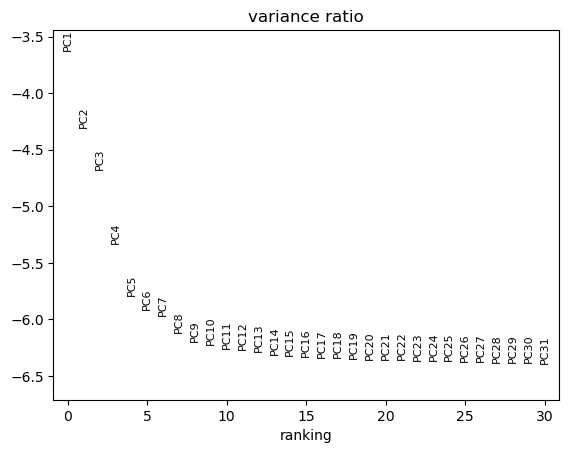

In [20]:
#elbowplot, to know the number of PCA we need for our neighbors
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
# UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=31)
sc.tl.umap(adata)

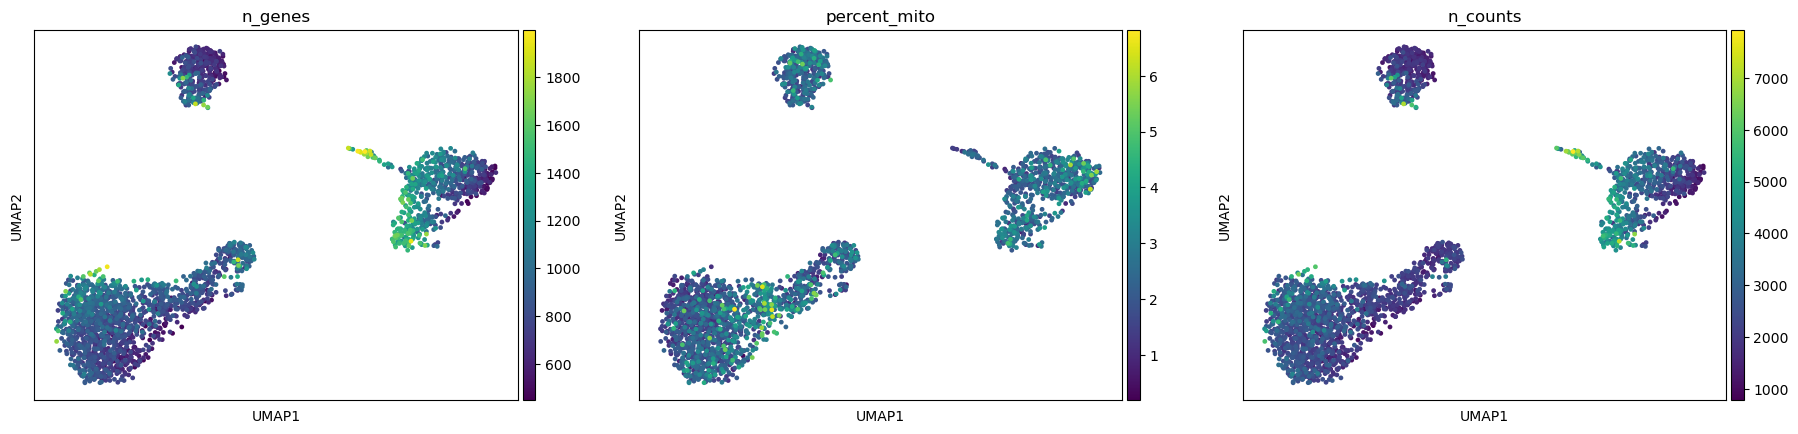

In [22]:
sc.pl.umap(adata, color=['n_genes', 'percent_mito', 'n_counts'])


In [23]:

adata = sc.read_h5ad("sc_dt_clustered_obourbia.h5ad")

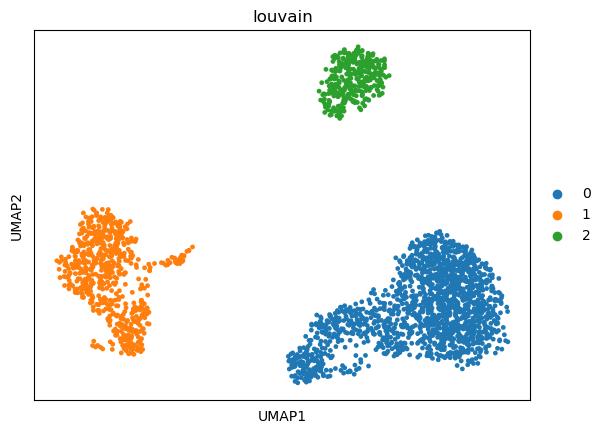

In [24]:
# uMAP clustering
sc.tl.leiden(adata, key_added='louvain', resolution=0.1)
sc.pl.umap(adata, color='louvain')

In [25]:
adata.var_names= list(adata.var.genes)
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2', 'SRSF10'],
      dtype='object', length=13714)

umap de lymphocyte T est:


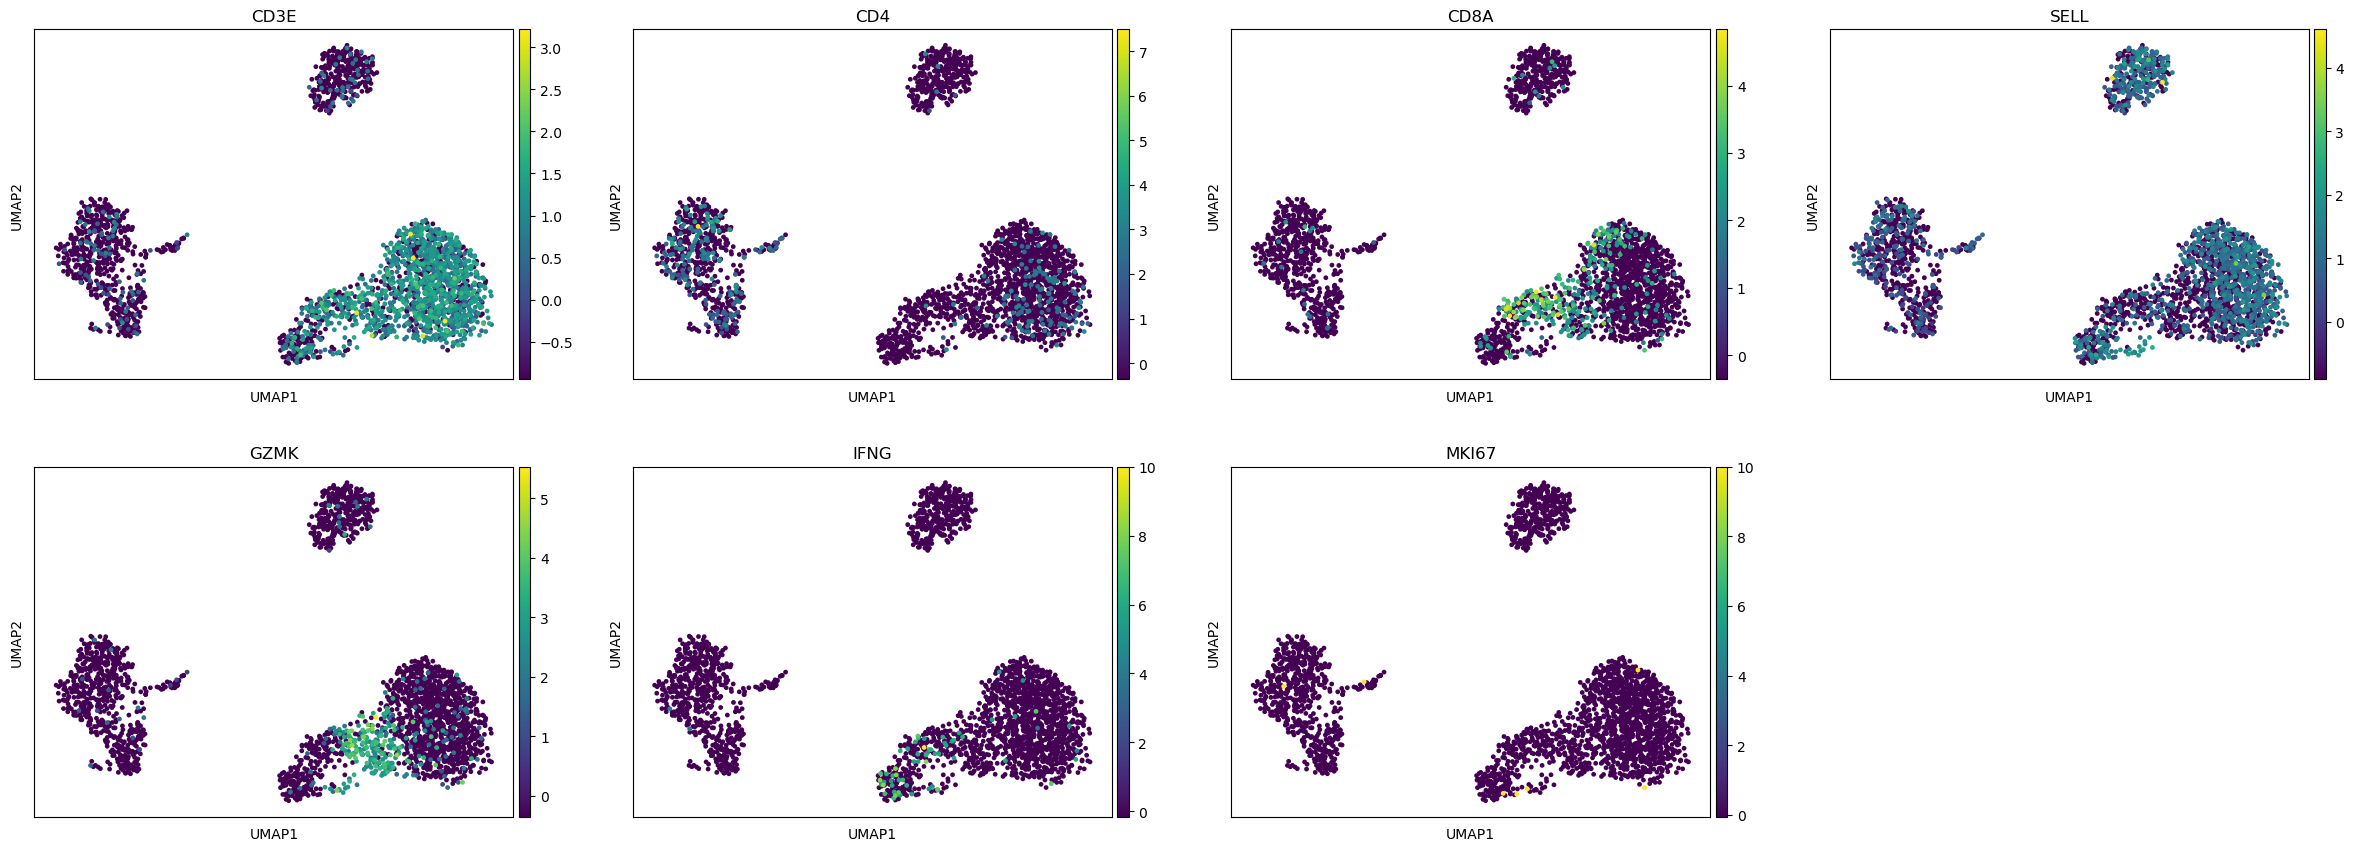

umap de cellule myeloid est:


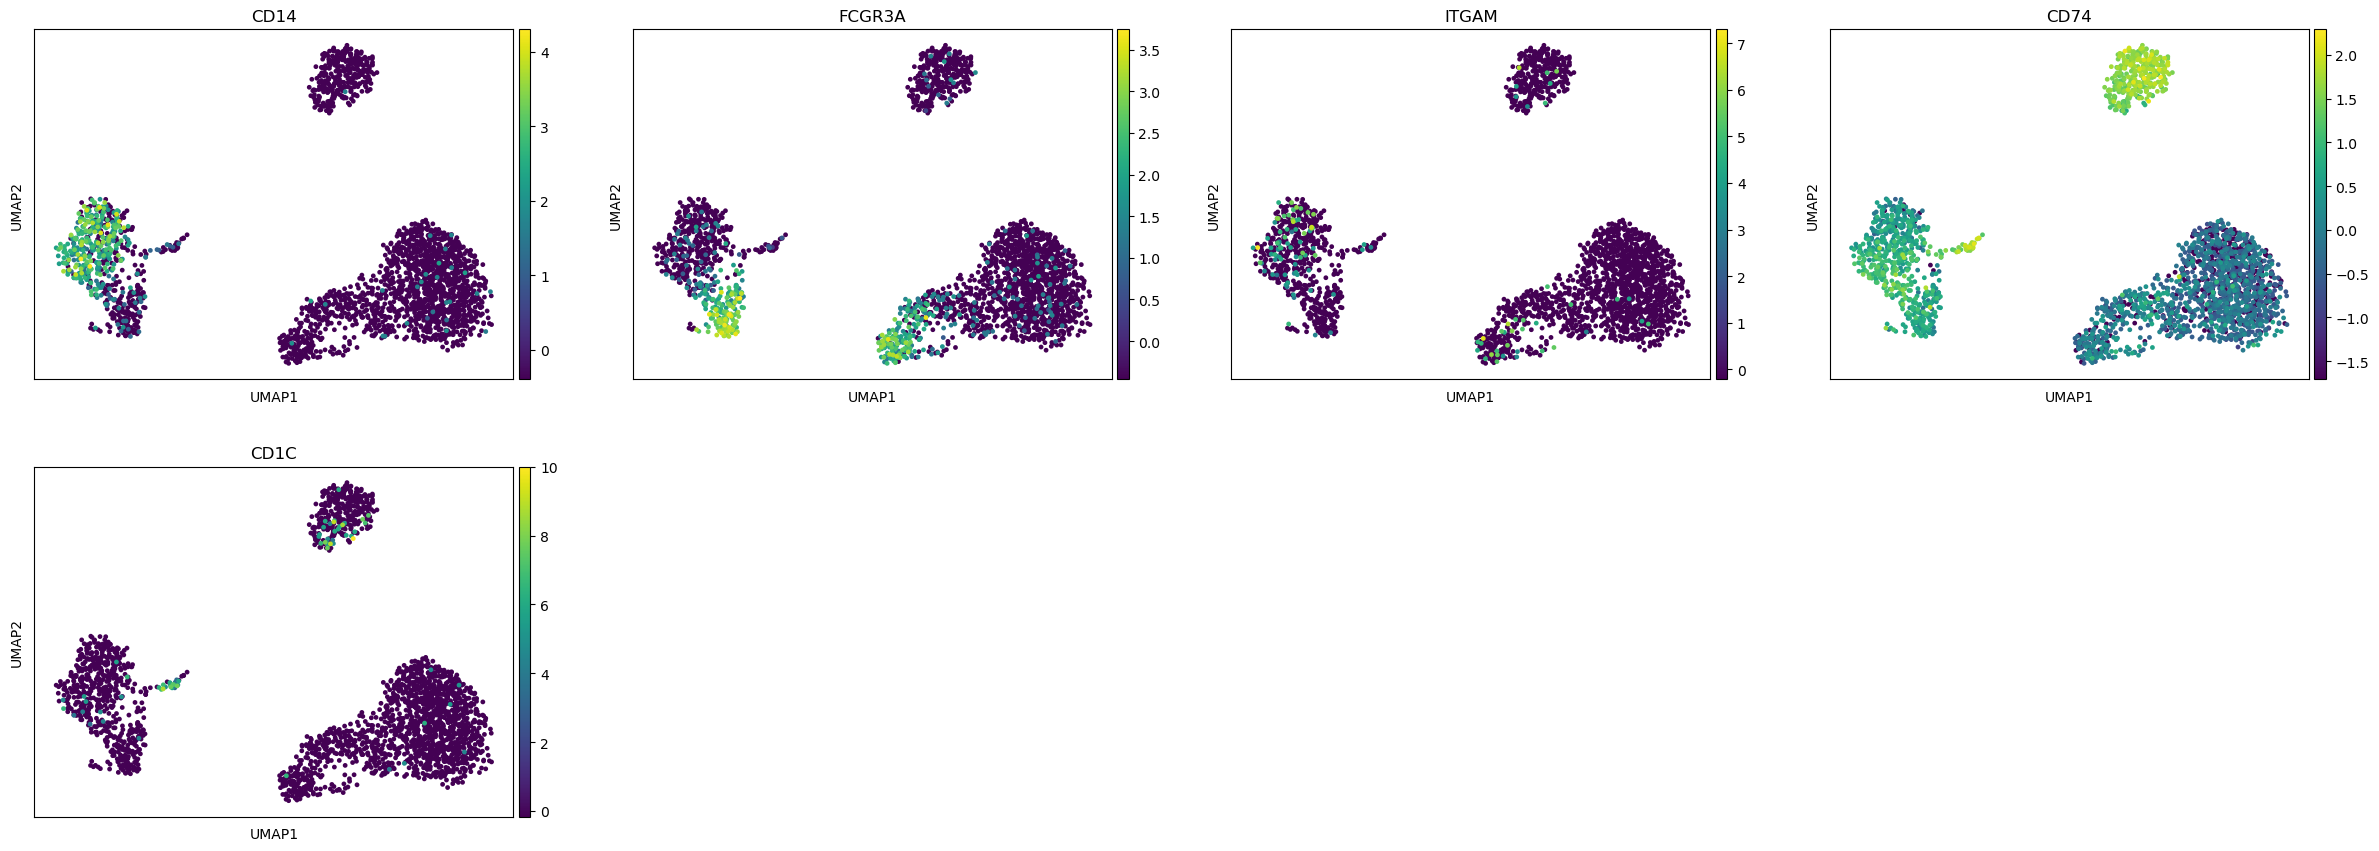

In [26]:
print("umap de lymphocyte T est:")
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67"])

print("umap de cellule myeloid est:")
sc.pl.umap(adata, color=['CD14', 'FCGR3A', 'ITGAM', 'CD74', 'CD1C'])

plt.show()

des gènes d'immunoglobuline qui commence par IGH  ['IGHMBP2']
des gènes d'immunoglobuline qui commence par IGL ['IGLL5']
umap de Bcell est:


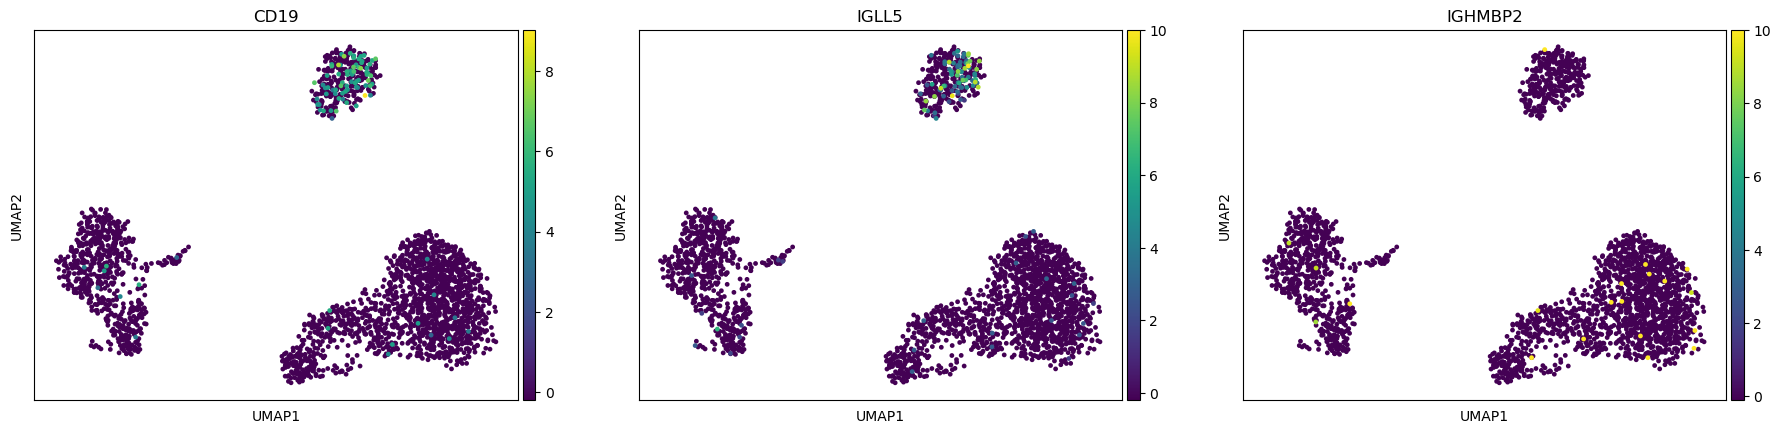

In [27]:
IGH= adata.var_names.str.startswith('IGH')
lis_IGH=[]
for i in range(len(IGH)): 
    if IGH[i]==True:
        lis_IGH.append(adata.var_names[i])
print("des gènes d'immunoglobuline qui commence par IGH ",lis_IGH)

IGL= adata.var_names.str.startswith('IGL')
lis_IGL=[]
for j in range(len(IGL)):
    if IGL[j]==True:
        lis_IGL.append(adata.var_names[j])
print("des gènes d'immunoglobuline qui commence par IGL",lis_IGL) 
print("umap de Bcell est:")
sc.pl.umap(adata, color=['CD19', 'IGLL5','IGHMBP2'])

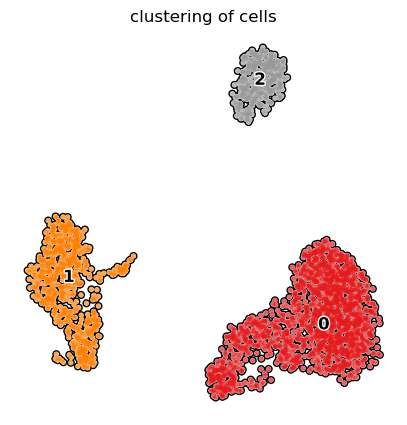

In [28]:
sc.tl.leiden(adata, key_added='clusters', resolution=0.1)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')


categories: 0, 1, 2
var_group_labels: Lymphocyte T, Bcell, cellule myeloid


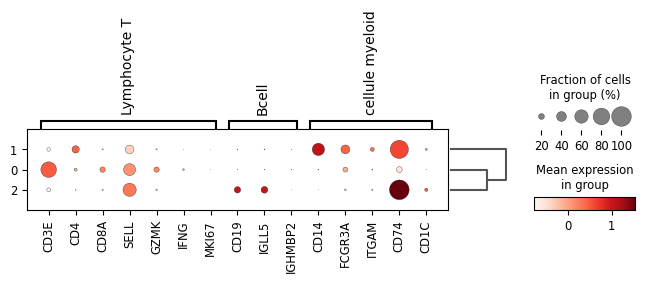

In [29]:

marker_genes_dict = {
    'Lymphocyte T': ["CD3E", "CD4", "CD8A", "SELL", "GZMK", "IFNG", "MKI67"], 
    'Bcell': ['CD19', 'IGLL5','IGHMBP2'],
    'cellule myeloid': [ 'CD14', 'FCGR3A', 'ITGAM', 'CD74', 'CD1C'], 
}
adata.var_names_make_unique() #  this line to delete duplicated genes and less only one copy

#dotplot
sc.pl.dotplot(adata , marker_genes_dict, 'clusters', dendrogram=True) # dendrogram to bring together similar cluster

categories: 0, 1, 2
var_group_labels: Lymphocyte T, Bcell, cellule myeloid


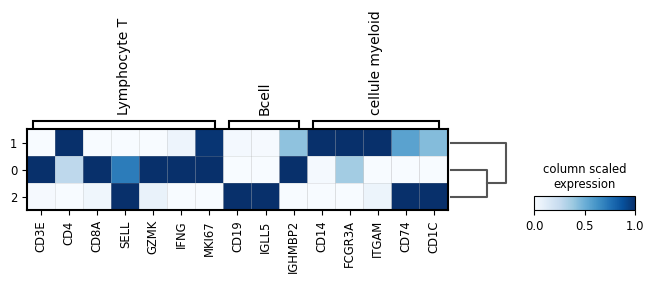

In [30]:

# matrixplot
sc.pl.matrixplot(adata, marker_genes_dict, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')


In [31]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Lymphocyte T',
     '1': 'cellule myeloid',
     '2': 'Bcell',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

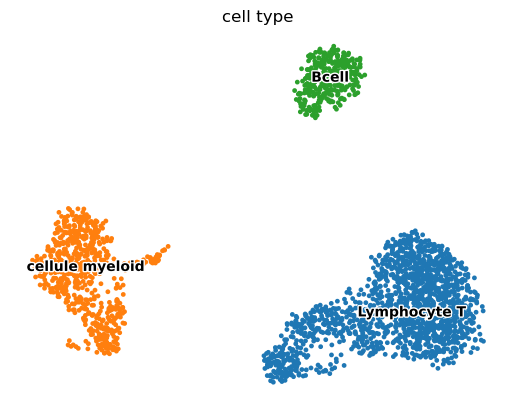

In [32]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

In [33]:
X = adata.X

# Center the data
X = X - np.mean(X, axis=0)

# Normalize the data
X = X / np.std(X, axis=0)

# Assign the scaled expression matrix back to adata
adata.X = X

C:\Users\oussama\AppData\Local\Temp\ipykernel_11012\4264785626.py:7: RuntimeWarning: invalid value encountered in true_divide
  X = X / np.std(X, axis=0)


categories: 0, 1, 2
var_group_labels: Lymphocyte T, Bcell, cellule myeloid


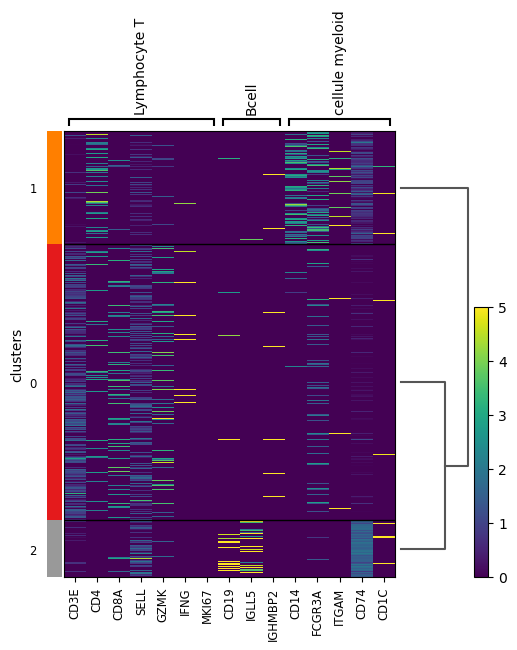

In [34]:
#heatMap
sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters',vmin=0, vmax=5, cmap='viridis', dendrogram=True)


# differential analysis

In [35]:
sc.pp.log1p(adata) # log-transforming the data
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test')

D:\condaa\lib\site-packages\scanpy\preprocessing\_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
D:\condaa\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
D:\condaa\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
D:\condaa\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


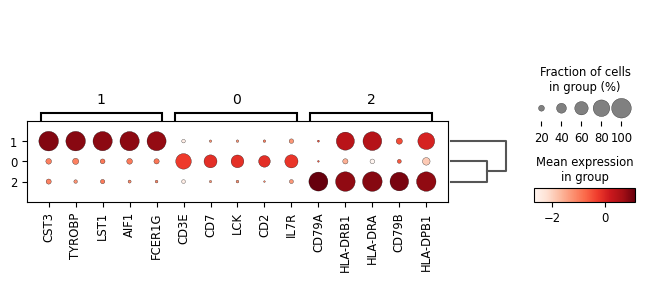

In [36]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5) # n_genes=5 to show only the top 5 scoring genes.

In [39]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X
adata.layers


Layers with keys: scaled

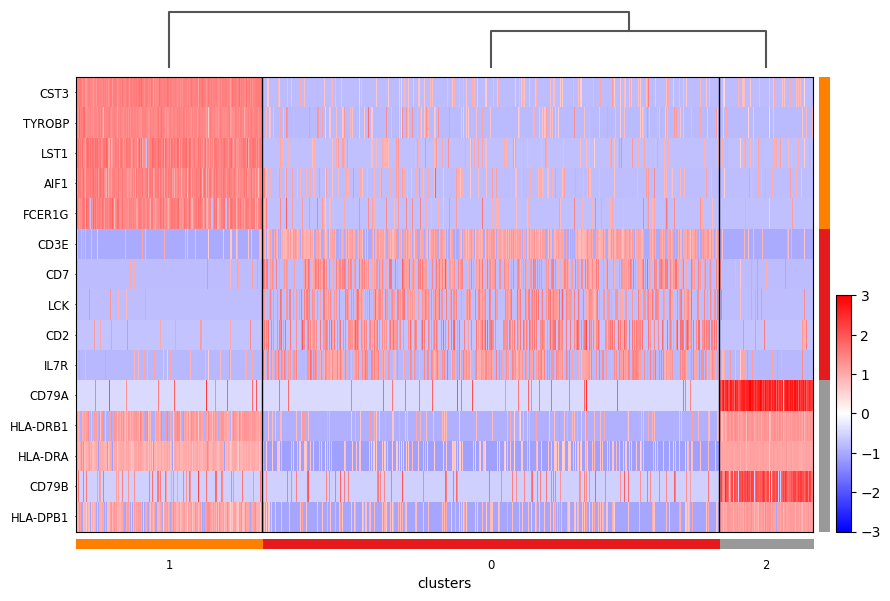

In [40]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);
